In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install csaps

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 304 µs (started: 2021-06-29 16:28:40 +00:00)


In [ ]:
cd '/content/drive/MyDrive/BTL'

/content/drive/MyDrive/BTL
time: 11.3 ms (started: 2021-06-29 16:28:40 +00:00)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import csaps
import glob

time: 959 ms (started: 2021-06-29 16:28:40 +00:00)


In [ ]:
def sobel(gray_img):
  kernel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
  ])
  dx = cv2.filter2D(gray_img, -1, kernel_x)

  kernel_y = np.array([
      [-1, -2, -1],
      [ 0,  0,  0],
      [ 1,  2,  1]
  ])
  dy = cv2.filter2D(gray_img, -1, kernel_y)

  mag = np.hypot(dx, dy)
  mag *= 255.0 / np.max(mag)  # normalize
  return mag.astype('uint8')

def horizontal_projection_profile(image, r, w):
  start = w*r
  return np.sum(image[:,start:start+w], axis = 1)

def smooth_horizontal_projection_profile(image, r, smt):
  w = int(image.shape[1]/r)
  P = []
  for i in range(r):
    pi = horizontal_projection_profile(image, i, w)
    P.append(pi)

  SP = []
  for p in P:
    x = range(p.shape[0])
    g = csaps.CubicSmoothingSpline(x, p, smooth=smt)
    sp = g(x)
    SP.append(sp)
  return SP


def min_distance(y, col):
  min = 1e9
  index = -1
  for i in range(len(col)):
    diff = abs(y - col[i])
    if diff < min:
      min = diff
      index = i
    elif diff > min:
      break;
  return min, index

def isLocalMax(sp, i):
  return all( [True if sp[i] > sp[i-j] and sp[i] > sp[i+j] 
               else False for j in range(1, 6)] )

def make_point(y, r, w):
  return (int(r*w + w/2), y)

def get_point_list(point, points_container):
  if not points_container:
    return []
  for points in points_container:
    if points[-1] == point:
      return points
  return []

def bresenham_line(x0, y0, x1, y1):
    steep = abs(y1 - y0) > abs(x1 - x0)
    if steep:
        x0, y0 = y0, x0  
        x1, y1 = y1, x1

    switched = False
    if x0 > x1:
        switched = True
        x0, x1 = x1, x0
        y0, y1 = y1, y0

    if y0 < y1: 
        ystep = 1
    else:
        ystep = -1

    deltax = x1 - x0
    deltay = abs(y1 - y0)
    error = -deltax / 2
    y = y0

    line = []    
    for x in range(x0, x1 + 1):
        if steep:
            line.append((y,x))
        else:
            line.append((x,y))

        error = error + deltay
        if error > 0:
            y = y + ystep
            error = error - deltax
    if switched:
        line.reverse()
    return line

def make_line(point_list, m):
  line = []
  for i in range(point_list[0][0]):
    line.append(point_list[0][1])
  
  for i in range(len(point_list) - 1):
    raw_line = bresenham_line(point_list[i][0], point_list[i][1], 
                       point_list[i+1][0], point_list[i+1][1])
    
    for x, y in raw_line:
      line.append(y)
    line.pop(-1)
  
  for i in range(point_list[-1][0], m):
    line.append(point_list[-1][1])  
  return line

def make_lines(SP, r, m):
  w = int(m/r)
  # tìm local max
  locals_max = []
  for sp in SP:
    l = []
    for i in range(5, len(sp)-5):
      if sp[i] > sp[i-1] and sp[i] > sp[i+1]:
        if(isLocalMax(sp, i)):
          l.append(i)
    locals_max.append(l)
  # tìm max hợp lệ
  points_container = []
  for i in range(r-1):
    for j in locals_max[i]:
      d1, h2 = min_distance(j, locals_max[i+1])
      d2, h1 = min_distance(locals_max[i+1][h2], locals_max[i])
      if d1 == d2:
        point1 = make_point(j, i, w)
        point2 = make_point(locals_max[i+1][h2], i+1, w)
        
        point_list = get_point_list(point1, points_container)
        if not point_list:
          point_list.append(point1)
          points_container.append(point_list)
        
        point_list.append(point2)
  # tạo line
  lines = []
  for point_list in points_container:
    line = make_line(point_list, m)
    lines.append(line)

  lines.sort(key=lambda line : line[0])
  return lines

def compute_energy_map(img):
  kernel0 = np.array([
      [0, 0, 0],
      [-1, 0, 1],
      [0, 0, 0]
  ])
  E0 = abs(cv2.filter2D(img, cv2.CV_64F, kernel0))
  E90 = abs(cv2.filter2D(img, cv2.CV_64F, kernel0.T))

  kernel45 = np.array([
    [0, 0, 1], 
    [0, 0, 0], 
    [-1, 0, 0]
  ])
  E45 = abs(cv2.filter2D(img, cv2.CV_64F, kernel45))
  E135 = abs(cv2.filter2D(img, cv2.CV_64F, np.flipud(kernel45)))

  E = (E0 + E45 + E90 + E135)/4

  se = np.array(
      [[0, 1, 0],
      [1, 1, 1],
      [0, 1, 0]], dtype=np.uint8)
  E = cv2.dilate(E, se)
  E = cv2.erode(E, se)
  return E

def compute_cumulative_minimum_energy(upper, lower, E, M):
  def get_m(x, y):
    if y <= upper[x] or y >= lower[x]:
      return 1e9
    return M[y][x]
  m = E.shape[1]
  for x in range(1, m):
    for y in range(upper[x]+1, lower[x]):
      M[y][x] = E[y][x] + min([get_m(x-1, y-1), 
                              get_m(x-1, y),
                              get_m(x-1, y+1)])

def traceback(upper, lower, E, M):
  seam = []
  # tìm min
  y_min = upper[-1]+1
  s_min = M[y_min][-1]
  for y in range(y_min + 1, lower[-1]):
    if M[y][-1] < s_min:
      s_min = M[y][-1]
      y_min = y

  seam.append(y_min)
  # truy vết
  m = E.shape[1]
  s_min -= E[y_min][-1]
  for x in range(m-2, -1, -1):
    for dy in [0, -1, 1]: # -1, 0, 1
      if y_min+dy <= upper[x] or y_min+dy >= lower[x]:
        continue
      if s_min == M[y_min+dy][x]:
        y_min += dy
        seam.append(y_min)
        s_min -= E[y_min][x]
        break
    else:
      pass
  
  seam.reverse()
  return seam

def make_seams(lines, E):
  seams = []
  M = E.copy()
  for i in range(len(lines) - 1):
    compute_cumulative_minimum_energy(lines[i], lines[i+1], E, M)
    seam = traceback(lines[i], lines[i+1], E, M)
    seams.append(seam)
  return seams

def compute_medial_seam(gray_img, r, smooth):
  n, m = gray.shape
  w = int(m/r)

  sobel_img = sobel(gray_img)
  SP = smooth_horizontal_projection_profile(sobel_img, r, smooth)
  lines = make_lines(SP, r, m)
  
  return lines

def compute_separating_seam(gray_img, lines, sd):
  gaussian_img = cv2.GaussianBlur(gray, (5, 5), sd)
  E = compute_energy_map(gaussian_img)
  seams = make_seams(lines, E)
  return seams

def seam_caving(gray_img, slice, smooth, sd):
  lines = compute_medial_seam(gray_img, slice, smooth)
  seams = compute_separating_seam(gray_img, lines, sd)
  return lines, seams

time: 672 ms (started: 2021-06-29 16:28:42 +00:00)


In [ ]:
def show_image(img, seams=None, lines=None, size=(10, 10)):
  plt.figure(figsize = size)
  plt.imshow(img, cmap='gray', norm=NoNorm())
  if seams:
    for seam in seams:
      plt.plot(range(len(seam)), seam, 'r')
  if lines:
    for line in lines:
      plt.plot(range(len(line)), line, 'c')
  plt.show()

time: 10.4 ms (started: 2021-06-29 16:28:48 +00:00)


In [ ]:
file_names = glob.glob('images/*.png')

time: 2.78 ms (started: 2021-06-29 10:26:30 +00:00)


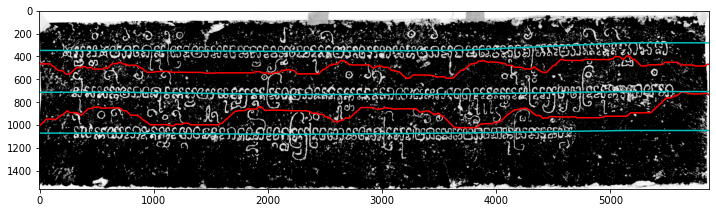

time: 15.7 s (started: 2021-06-29 16:29:35 +00:00)


In [ ]:
gray = cv2.imread('images/C 3 A1.png', 0)
lines, seams = seam_caving(gray, 4, 1e-6, 0.5)
show_image(gray, seams, lines, size=(12, 12))

Đường phân chia đúng: 2

Đường loại I: 0 \\
Đường loại II: 2 \\
Đường loại III: 0 \\
Đường loại IV: 0 \\
Tổng: 2

Precision = 2/2 = 100% \\
Recall = 2/2 = 100%

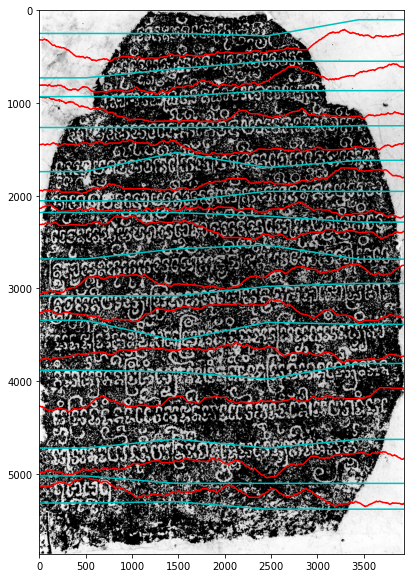

time: 1min 10s (started: 2021-06-22 17:06:20 +00:00)


In [ ]:
gray = cv2.imread(file_names[0], 0)
lines, seams = seam_caving(gray, 4, 0.0000001, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 13

Đường loại I: 1 \\
Đường loại II: 7 \\
Đường loại III: 3 \\
Đường loại IV: 2 \\
Tổng: 13

Precision = 8/13 = 61.54% \\
Recall: 8/13 = 61.54%

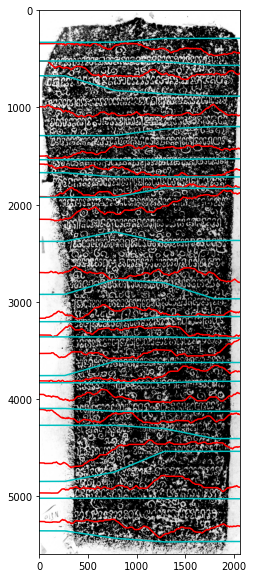

time: 35.2 s (started: 2021-06-22 18:37:59 +00:00)


In [ ]:
gray = cv2.imread(file_names[1], 0)
lines, seams = seam_caving(gray, 4, 1e-7, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 22

Đường loại I: 0 \\
Đường loại II: 10 \\
Đường loại III: 4 \\
Đường loại IV: 3 \\
Tổng: 17

Precision = 10/17 = 58.82% \\
Recall: 10/22 = 45.45%

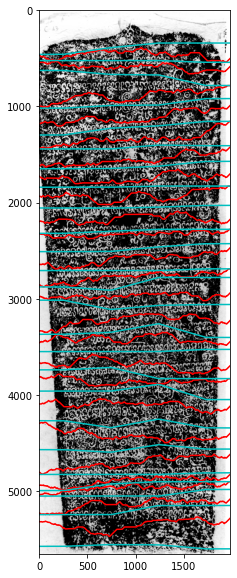

time: 37 s (started: 2021-06-22 17:08:07 +00:00)


In [ ]:
gray = cv2.imread(file_names[2], 0)
lines, seams = seam_caving(gray, 4, 0.000001, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 22

Đường loại I: 1 \\
Đường loại II: 14 \\
Đường loại III: 4 \\
Đường loại IV: 5 \\
Tổng: 24

Precision = 15/24 = 62.5% \\
Recall: 15/22 = 68.18%

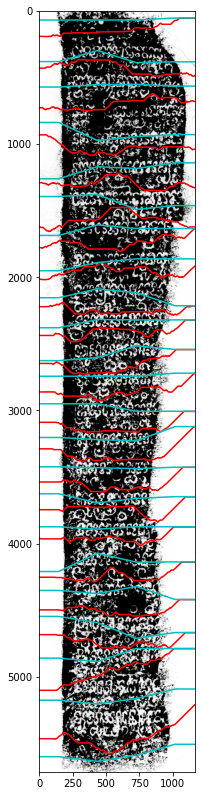

time: 23.1 s (started: 2021-06-26 10:44:03 +00:00)


In [ ]:
gray = cv2.imread(file_names[3], 0)
lines, seams = seam_caving(gray, 4, 0.000001, 0.5)
show_image(gray, seams, lines, size=(14, 14))

Đường phân chia đúng: 22

Đường loại I: 0 \\
Đường loại II: 15 \\
Đường loại III: 4 \\
Đường loại IV: 3 \\
Tổng: 22

Precision = 15/22 = 68.18% \\
Recall: 15/22 = 68.18%

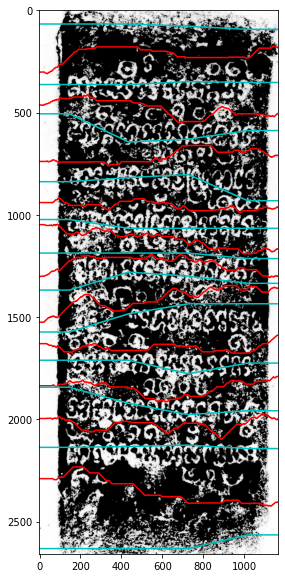

time: 11.9 s (started: 2021-06-22 17:09:06 +00:00)


In [ ]:
gray = cv2.imread(file_names[4], 0)
lines, seams = seam_caving(gray, 4, 0.000001, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 8

Đường loại I: 0 \\
Đường loại II: 5 \\
Đường loại III: 3 \\
Đường loại IV: 3 \\
Tổng: 11

Precision = 5/11 = 45.45% \\
Recall: 5/8 = 62.5%

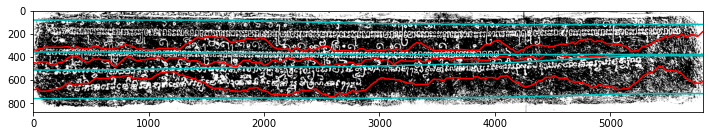

time: 12.5 s (started: 2021-06-26 18:56:56 +00:00)


In [ ]:
gray = cv2.imread(file_names[5], 0)
lines, seams = seam_caving(gray, 5, 1e-6, 0.5)
show_image(gray, seams, lines, size=(12, 12))

Đường phân chia đúng: 3

Đường loại I: 0 \\
Đường loại II: 1 \\
Đường loại III: 0 \\
Đường loại IV: 2 \\
Tổng: 3

Precision = 1/3 = 33.33% \\
Recall: 1/3 = 33.33%

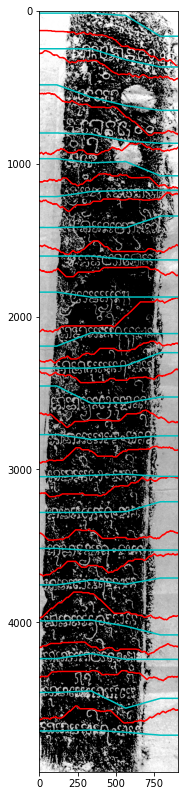

time: 15.7 s (started: 2021-06-26 10:39:17 +00:00)


In [ ]:
gray = cv2.imread(file_names[6], 0)
lines, seams = seam_caving(gray, 4, 0.000001, 0.5)
show_image(gray, seams, lines, size=(14, 14))

Đường phân chia đúng: 19

Đường loại I: 12 \\
Đường loại II: 6 \\
Đường loại III: 0 \\
Đường loại IV: 2 \\
Tổng: 20

Precision = 18/20 = 90% \\
Recall: 18/19 = 94.73%

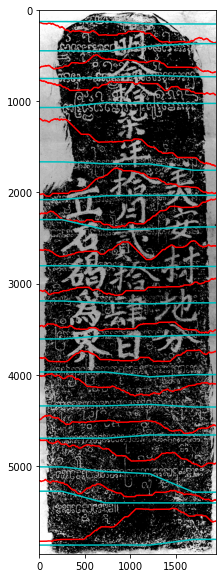

time: 36.9 s (started: 2021-06-22 18:37:07 +00:00)


In [ ]:
gray = cv2.imread(file_names[7], 0)
lines, seams = seam_caving(gray, 4, 1e-7, 0.5)
show_image(gray, seams, lines)

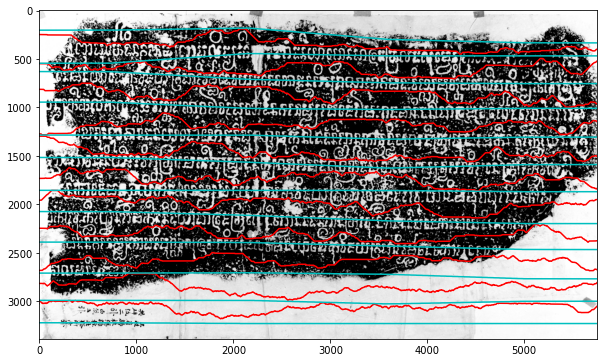

time: 58.4 s (started: 2021-06-22 17:10:25 +00:00)


In [ ]:
gray = cv2.imread(file_names[8], 0)
lines, seams = seam_caving(gray, 4, 0.000001, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 8

Đường loại I: 0 \\
Đường loại II: 7 \\
Đường loại III: 1 \\
Đường loại IV: 3 \\
Tổng: 11

Precision = 7/11 = 63.64% \\
Recall: 7/8 = 87.5%

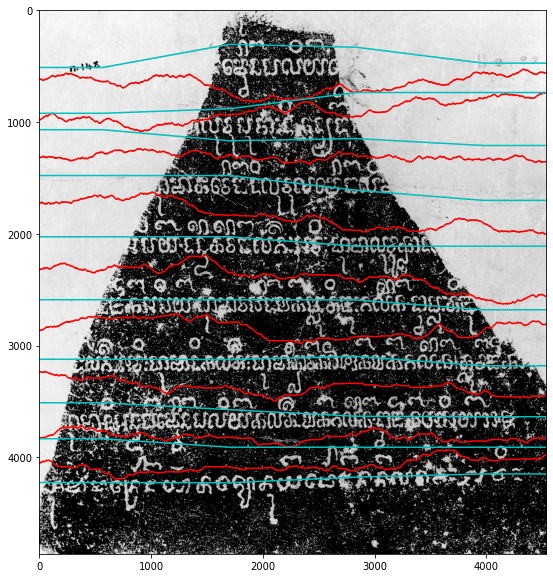

time: 57.6 s (started: 2021-06-22 18:36:05 +00:00)


In [ ]:
gray = cv2.imread(file_names[9], 0)
lines, seams = seam_caving(gray, 4, 1e-7, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 7

Đường loại I: 3 \\
Đường loại II: 3 \\
Đường loại III: 1 \\
Đường loại IV: 2 \\
Tổng: 9

Precision = 6/9 = 66.67% \\
Recall: 6/7 = 85.71%

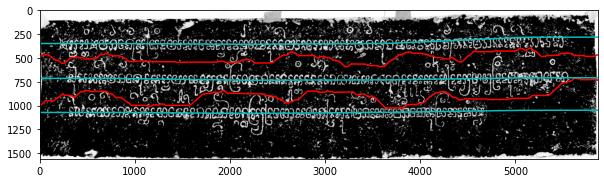

time: 16 s (started: 2021-06-22 17:32:54 +00:00)


In [ ]:
gray = cv2.imread(file_names[10], 0)
lines, seams = seam_caving(gray, 4, 0.000001, 0.5)
show_image(gray, seams, lines)

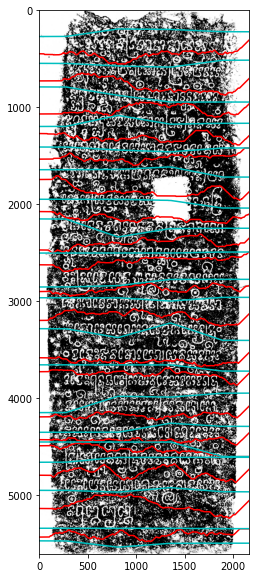

time: 37.3 s (started: 2021-06-29 10:26:49 +00:00)


In [ ]:
gray = cv2.imread(file_names[11], 0)
lines, seams = seam_caving(gray, 4, 2e-7, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 18

Đường loại I: 1 \\
Đường loại II: 14 \\
Đường loại III: 3 \\
Đường loại IV: 1 \\
Tổng: 19

Precision = 15/19 = 78.95% \\
Recall: 15/18 = 83.33%

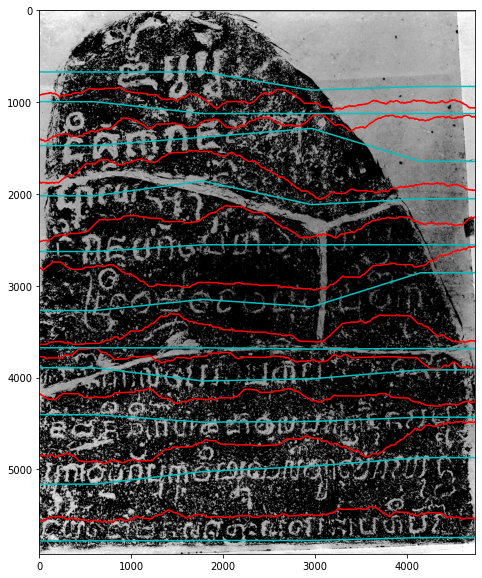

time: 1min 18s (started: 2021-06-22 17:52:37 +00:00)


In [ ]:
gray = cv2.imread(file_names[12], 0)
lines, seams = seam_caving(gray, 4, 0.0000001, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 8

Đường loại I: 4 \\
Đường loại II: 4 \\
Đường loại III: 0 \\
Đường loại IV: 2 \\
Tổng: 10

Precision = 8/10 = 80% \\
Recall: 8/8 = 100%

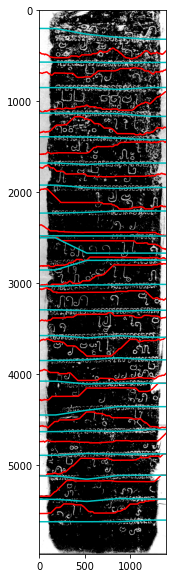

time: 24.5 s (started: 2021-06-22 18:34:42 +00:00)


In [ ]:
gray = cv2.imread(file_names[13], 0)
lines, seams = seam_caving(gray, 4, 3e-7, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 20

Đường loại I: 1 \\
Đường loại II: 17 \\
Đường loại III: 2 \\
Đường loại IV: 1 \\
Tổng: 21

Precision = 18/21 = 85.71% \\
Recall: 18/20 = 90%

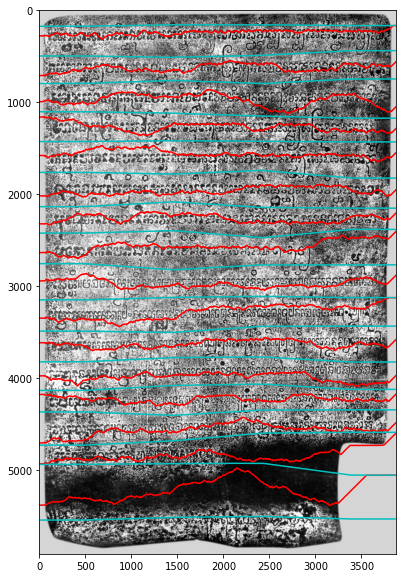

time: 1min 10s (started: 2021-06-22 17:35:47 +00:00)


In [ ]:
gray = cv2.imread(file_names[14], 0)
lines, seams = seam_caving(gray, 4, 0.0000007, 0.5)
show_image(gray, seams, lines)

Đường phân chia đúng: 15

Đường loại I: 1 \\
Đường loại II: 0 \\
Đường loại III: 0 \\
Đường loại IV: 15 \\
Tổng: 16

Precision = 1/16 = 6.25% \\
Recall = 1/15 = 6.67%

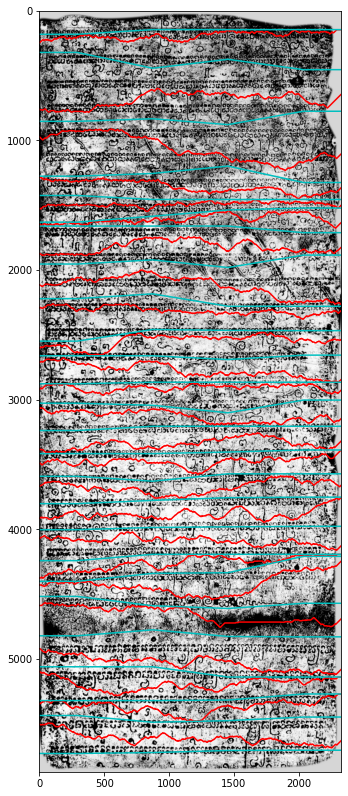

time: 44.7 s (started: 2021-06-26 11:53:10 +00:00)


In [ ]:
gray = cv2.imread(file_names[15], 0)
lines, seams = seam_caving(gray, 4, 1e-6, 0.5)
show_image(gray, seams, lines, size=(14, 14))

Đường phân chia đúng: 28

Đường loại I: 1 \\
Đường loại II: 12 \\
Đường loại III: 3 \\
Đường loại IV: 8 \\
Tổng: 24

Precision = 13/24 = 54.16% \\
Recall: 13/28 = 46.43%

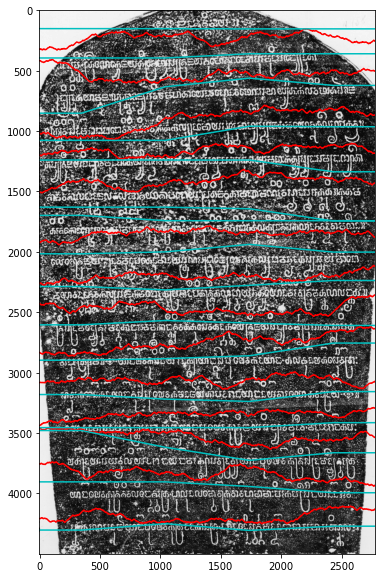

time: 36.5 s (started: 2021-06-29 10:48:03 +00:00)


In [ ]:
gray = cv2.imread(file_names[19], 0)
lines, seams = seam_caving(gray, 4, 2e-7, 1)
show_image(gray, seams, lines)

Đường phân chia đúng: 15

Đường loại I: 1 \\
Đường loại II: 11 \\
Đường loại III: 0 \\
Đường loại IV: 2 \\
Tổng: 14

Precision = 12/14 = 85.71% \\
Recall: 12/15 = 80%